In [ ]:
# moduli usati
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy  as np

# Leggiamo i dati di APPA

Come nella precedente lezione carichiamo i dati di APPA, selezioniamo la stazione e calcoliamo i valori medi giornalieri per ogni inquinante in modo da ottenere la tabella pivot usata per il calcolo della correlazione nella scorsa lezione.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
data_folder = Path("/content/drive/MyDrive/data")
appa = pd.read_csv(
    data_folder / "DataSet_APPA/processed/appa_data.csv", parse_dates=["Data"]
)
# definiamo la stazione da analizzare
station = "Piana Rotaliana"
exp_data = appa.loc[(appa.Stazione == station)].set_index("Data").groupby(["Inquinante"]).resample("D").mean("Valore").reset_index()
# converto i nomi degli inquinanti in codici (formule chimiche o abbreviazioni)
exp_data["Inquinante"] = exp_data.Inquinante.map(
    {"PM10": "PM10", "Biossido di Azoto": "NO2", "Ozono": "O3"}
)
# converto il dataframe in una tabella pivot (formato wide) e ordino i dati per data
exp_data = exp_data.pivot_table(
    index="Data", columns="Inquinante", values="Valore"
).sort_index()

exp_data

Inquinante,NO2,O3,PM10
Data,,,
2011-01-01,40.913043,8.652174,42.304348
2011-01-02,49.666667,8.083333,36.125000
2011-01-03,29.125000,30.250000,20.458333
2011-01-04,32.458333,21.750000,27.916667
2011-01-05,34.833333,20.791667,30.416667
...,...,...,...
2023-12-29,28.500000,6.250000,22.541667
2023-12-30,25.750000,9.125000,22.875000
2023-12-31,26.708333,4.500000,22.083333


# Previsione del valore medio giornaliero di PM10 in base ai dati APPA

In base ai dati del nostro dataframe possiamo riuscire a prevedere il valore medio giornaliero di un inquinante, ad esempio il PM10?

I modelli di ML basati sulle regressioni possono essere applicati per prevedere la variazione di un valore nel tempo. Alla base di questi modelli ci sono i dati.

Proviamo a capire come costruire un set di dati a partire dal nostro dataset APPA. L'obiettivo è prevedere il valore medio di PM10 in base ai valori dei giorni precedenti.




## Costruzione del dato

Quali sono i dati e i valori che potrebbero essere utili? Sicuramente i valori di PM10 dei giorni precedenti o il valore medio della settimana precedente.

Il codice seguente permette di aggiungere al dataframe:
* una feature (colonna) di dati sfasati di un certo intervallo temporale, ad esempio 1 giorno,
`pollutant_series.shift(1).rename("lagged_poll_df_1d"),`
* una feature (colonna) di valori medi `.mean()`, massimi `.max()` o minimi `.min()` della settimana precedente (7 giorni).
`pollutant_series.shift(1).rolling(7).mean().rename("lagged_mean_week"),`
* informazioni sulla data come ad esempio giorno (day), settimana (week), mese (month), anno (year)
`pd.Series(pollutant_series.index.year, index=pollutant_series.index).rename("year")`

In [ ]:
pollutant = "PM10"
pollutant_series = exp_data[pollutant]
# mi assicuro di avere i dati ordinati per data
pollutant_series = pollutant_series.sort_index()


lagged_df = pd.concat([	pollutant_series,
						pollutant_series.shift(1).rename("lagged_poll_df_1d"),
						pollutant_series.shift(2).rename("lagged_poll_df_2d"),
						pollutant_series.shift(1).rolling(7).mean().rename("lagged_mean_week"),
						pollutant_series.shift(1).rolling(7).max().rename("lagged_max_week"),
						pollutant_series.shift(1).rolling(7).min().rename("lagged_min_week"),
						pd.Series(pollutant_series.index.year,
						index=pollutant_series.index).rename("year"),
						pd.Series(pollutant_series.index.day,
						index=pollutant_series.index).rename("day"),
						pd.Series(pollutant_series.index.month,
						index=pollutant_series.index).rename("month")
						],
					axis="columns",)

lagged_df.head(10)

#lagged_df.tail(10)


,PM10,lagged_poll_df_1d,lagged_poll_df_2d,lagged_mean_week,lagged_max_week,lagged_min_week,year,day,month
Data,,,,,,,,,
2011-01-01,42.304348,NaN,NaN,NaN,NaN,NaN,2011,1,1
2011-01-02,36.125000,42.304348,NaN,NaN,NaN,NaN,2011,2,1
2011-01-03,20.458333,36.125000,42.304348,NaN,NaN,NaN,2011,3,1
2011-01-04,27.916667,20.458333,36.125000,NaN,NaN,NaN,2011,4,1
2011-01-05,30.416667,27.916667,20.458333,NaN,NaN,NaN,2011,5,1
2011-01-06,27.916667,30.416667,27.916667,NaN,NaN,NaN,2011,6,1
2011-01-07,44.750000,27.916667,30.416667,NaN,NaN,NaN,2011,7,1
2011-01-08,57.375000,44.750000,27.916667,32.841097,44.750000,20.458333,2011,8,1
2011-01-09,69.416667,57.375000,44.750000,34.994048,57.375000,20.458333,2011,9,1


In [ ]:
# controllo le dimensioni
exp_data.shape, lagged_df.shape


((4737, 3), (4737, 9))

La colonna PM10 sono i valori medi giornalieri che dobbiamo prevedere. Le altre colonne costituiscono la matrice di input del modello.

In [ ]:

# seleziono i dati da utilizzare per addestrare il modello
# X rappresentato le variabili in input
# y rappresenta la variabile che vogliamo predire

X = lagged_df.dropna().drop(columns=pollutant)
y = lagged_df.dropna()[pollutant]
X.shape, y.shape

((4568, 8), (4568,))

## Suddivisione dei dati (data splitting)

I dati vengono suddivisi in due set.

L'**80%** costituisce il dataset (matrice più vettore) su cui **allenare** il modello.

Il restante 20% lo teniamo come test. Utilizziamo il 20% della matrice dei dati costruita da noi come **input** per prevedere i valori di PM10. Questi valori possono essere **confrontati** con il vettore di dati di PM10 misurati per capire la performance del modello.

In [ ]:
# shuffle False, quindi uso il primo 80% di dati per training, e il restante per test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3654, 8), (914, 8), (3654,), (914,))

## Training del modello

Utilizziamo un modello basato sulla regressione. Con il metodo fit andiamo a "creare" il modello che poi useremo per prevedere il valore di PM10 del giorno sucessivo.

In [ ]:
model = RandomForestRegressor(random_state=42)
# alleno il modello sugli ultimi 10000 punti di training
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

## Previsione sul test

Andiamo a prevedere il PM10 sul set di dati per il test (20%).

In [ ]:
y_pred = y_test.copy()

y_pred[:] = model.predict(X_test)
y_pred

test = pd.merge(
    y_test, y_pred, left_index=True, right_index=True, suffixes=("_true", "_pred")
)
test

,PM10_true,PM10_pred
Data,,
2021-06-10,14.458333,12.607340
2021-06-11,15.000000,16.017276
2021-06-12,16.250000,17.922554
2021-06-13,13.125000,16.710600
2021-06-14,19.083333,12.353301
...,...,...
2023-12-29,22.541667,19.632131
2023-12-30,22.875000,23.223910
2023-12-31,22.083333,21.283137


Grafichiamo i dati previsti e i misurati per confrontarli.

<Axes: title={'center': 'PM10'}, xlabel='Data'>

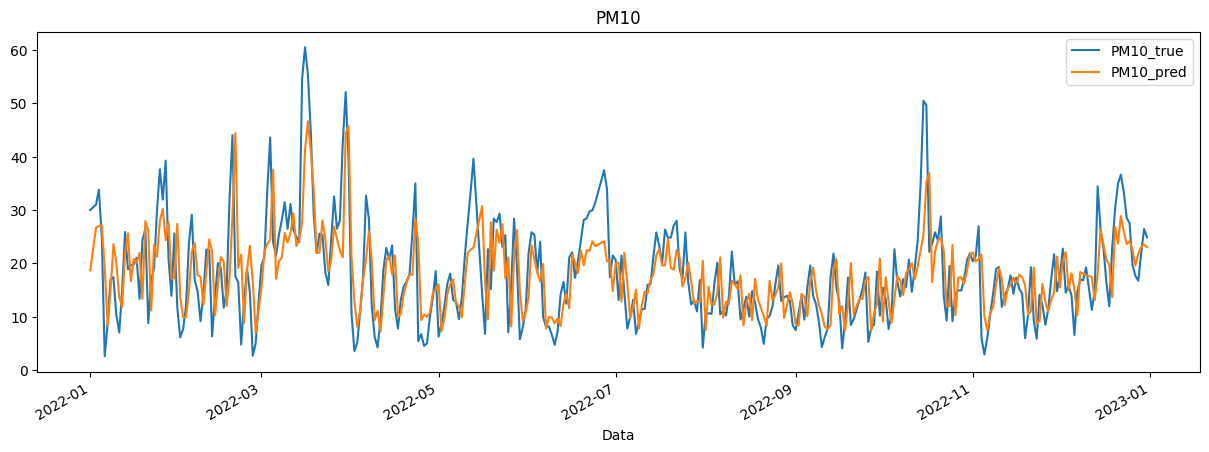

In [ ]:
test.loc["2022-01-01":"2022-12-31", ["PM10_true", "PM10_pred"]].plot(figsize=(15, 5), title="PM10")

<Axes: xlabel='Data'>

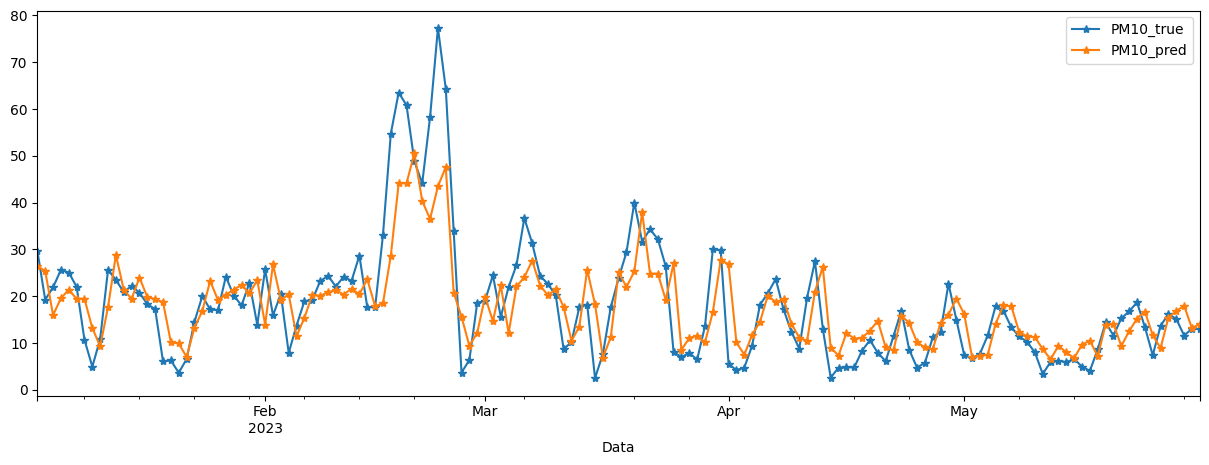

In [ ]:
test["2023-01-03":"2023-05-31"].plot(figsize=(15, 5), marker="*")

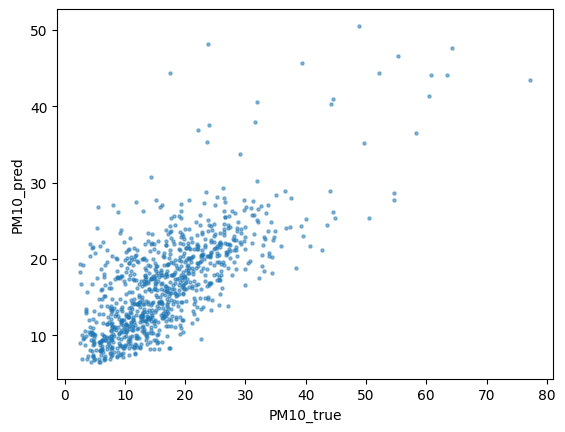

In [ ]:
ax = test.plot.scatter(x="PM10_true", y="PM10_pred", alpha=0.5, marker=".")
#ax.plot([0, 100], [0, 100], c="C1")


Valutiamo numericamente il coefficiente di determinazione (R^2).



In [ ]:
# valuto il modello (coefficiente di determinazione)
model.score(X_train, y_train), model.score(X_test, y_test)

(0.9267843542006913, 0.5173036778471733)

Per decidere quale colonna mantenere può essere utile capire quale features vengono usate maggiormente dal modello. Esiste un parametro, la feature importance, che può essere graficato come riportato di seguito.

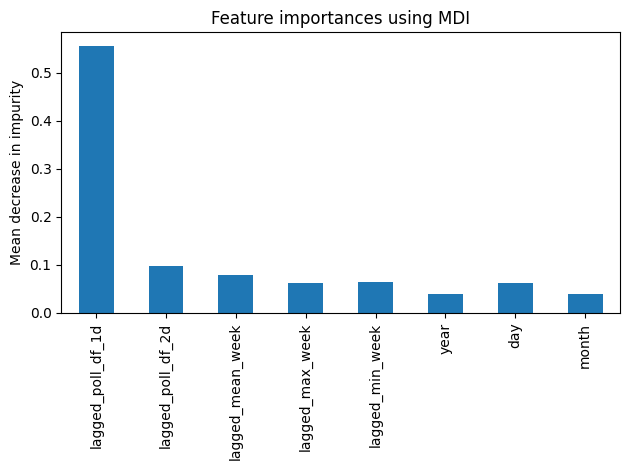

In [ ]:
from matplotlib import pyplot as plt

forest_importances = pd.Series(model.feature_importances_, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Osservazioni

*   Quali colonne abbiamo usato?
*   Ci sono altri dati che potrebbero essere utlizzati?